In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Preparing metadata (setup.py) ... done


In [2]:
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import HMC, MCMC, MixedHMC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data initialization

We initialize our data by creating a random input dataset X with 50 observations, each with 100 features.

We create a coefficient vector which will be our source of truth, setting the first value to 1 and all other values to 0.

We then create our output vector Y by multiplying our input dataset X with our coefficient vector, then proceeding to add noise.

In [3]:
n = 50
p = 100

X = np.random.rand(n, p)
coeff = np.array([1.0, 1.0] + (p - 2) * [0.0])

In [4]:
noise = 0.3
Y_star = X @ coeff + noise * np.random.rand(n)
Y = X @ coeff

In [ ]:
def model(key=None, x=None, y=None):

    se = numpyro.sample("se", dist.Normal(0.0, 1.0)) ## single-effect b
    gamma = numpyro.sample("gamma", dist.Categorical(probs=jnp.array([1/100.] * 100))) ## assuming uniform prior
    gamma_vector = jnp.array([0.0] * p)
    gamma_vector = gamma_vector.at[gamma].set(1.0)

    b = se * gamma_vector
    mu = jnp.matmul(x, b)

    z = random.multivariate_normal(key, mu, np.identity(n))

    numpyro.sample("obs", dist.Normal(z, 1.0), obs=y)

In [ ]:
key = random.PRNGKey(0)
kernel = MixedHMC(HMC(model), num_discrete_updates=20)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, progress_bar=True)
mcmc.run(key, key=key, x=X, y=Y_star)
mcmc.print_summary()
samples = mcmc.get_samples()


# Results

We see that the histogram distribution of gamma shows that most samples after our burn-in period give back 0, which is the index in the coefficient vector that has the singular value 1—this is the behavior that we desired.

We also see that the density distribution of the single effect centers at a median of 1.10, close to the true value of 1 for the coefficient vector.

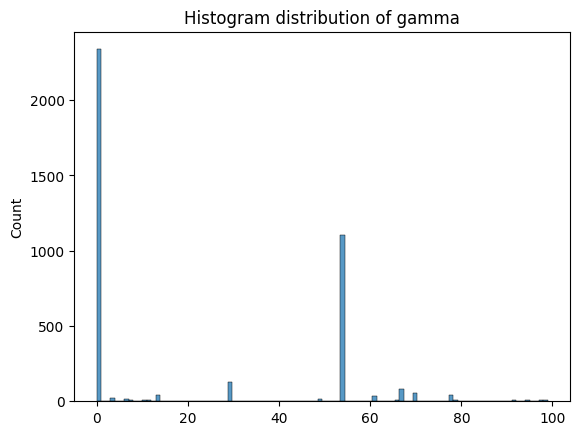

In [ ]:
sns.histplot(samples['gamma'], bins=p).set(title='Histogram distribution of gamma');

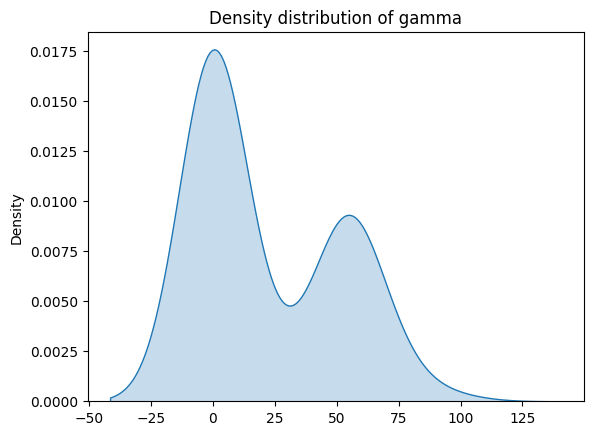

In [ ]:
sns.kdeplot(samples['gamma'], bw_method=0.5, fill=True).set(title='Density distribution of gamma');

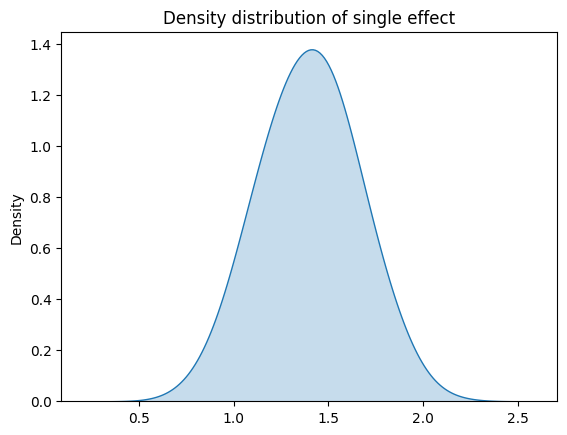

In [ ]:
sns.kdeplot(samples['se'], bw_method=0.5, fill=True).set(title='Density distribution of single effect');

# Posterior model

In [5]:
def posterior_model(x=None, y=None):

    n, p = x.shape
    num_samples = 1000

    sigma = sigma_0 = 1

    a = np.zeros(p)
    mu_vals = np.zeros(p)
    sig_vals = np.zeros(p)

    for j, x_j in enumerate(x.T):
        b_hat = (1 / jnp.dot(x_j, x_j)) * x_j.T @ y
        s = sigma / (jnp.dot(x_j, x_j))
        z = b_hat / jnp.sqrt(s)

        bf_j = jnp.sqrt(s / (sigma_0 + s)) * jnp.exp(z ** 2 / 2 * sigma_0 / (sigma_0 + s))
        a[j] = bf_j / p

        sig_vals[j] = 1 / (1 / s + 1 / sigma_0)
        mu_vals[j] = (sig_vals[j] / s) * b_hat

    a = a / jnp.sum(a)

    return a, mu_vals, sig_vals

In [6]:
a, mu_vals, sig_vals = posterior_model(X, Y_star)

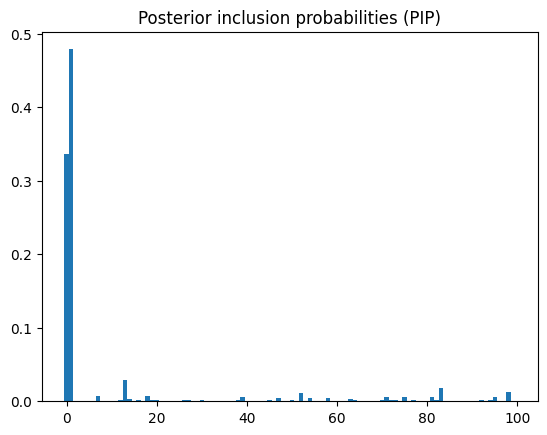

In [7]:
plt.bar(np.arange(p), a, width=1)
plt.title('Posterior inclusion probabilities (PIP)')
plt.show()

In [8]:
mu_0 = mu_vals[0]
print('The true mu value is {}'.format(mu_0))

The true mu value is 1.938624620437622


This time we get the distribution for the true values Y.

In [9]:
a_true, mu_vals, sig_vals = posterior_model(X, Y)

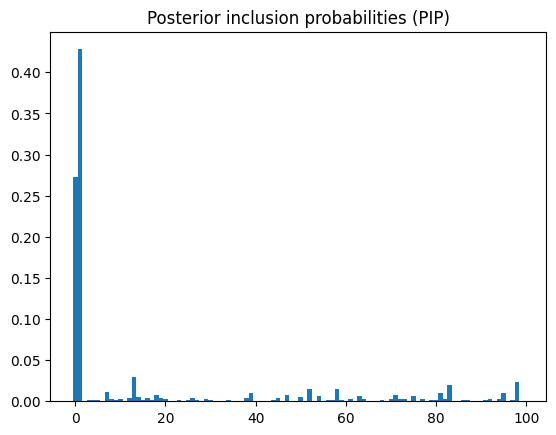

In [10]:
plt.bar(np.arange(p), a_true, width=1)
plt.title('Posterior inclusion probabilities (PIP)')
plt.show()

In [11]:
mu_0 = mu_vals[0]
print('The true mu value is {}'.format(mu_0))

The true mu value is 1.6944383382797241


# SuSiE model

In [12]:
def susie_model(x=None, y=None, L=None):
    n, p = x.shape

    b_vals, a_vals, mu_vals, sigma_vals = np.zeros((L, p)), np.zeros((L, p)), np.zeros((L, p)), np.zeros((L, p))

    r = y - X @ np.mean(b_vals, axis=0)

    for i in range(10):
        for l in range(L):
            r_l = r + X @ b_vals[l]
            a, mu, sigma = posterior_model(x, y)
            b_vals[l] = a * mu
            r = r_l - X @ b_vals[l]
            a_vals[l], mu_vals[l], sigma_vals[l] = a, mu, sigma

    return a_vals, mu_vals, sigma_vals

In [13]:
L = 10
a_vals, mu_vals, sigma_vals = susie_model(X, Y_star, 10)

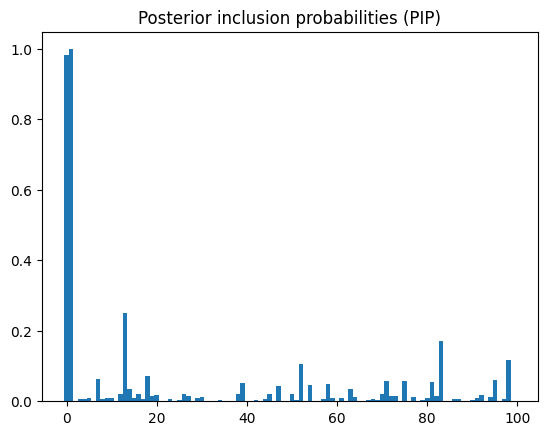

In [14]:
pip = np.zeros(p)
for i in range(p):
    pip[i] = 1 - np.prod(np.ones(L) - a_vals[:, i])
plt.bar(np.arange(p), pip, width=1)
plt.title('Posterior inclusion probabilities (PIP)')
plt.show()